In [1]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from coin_if import COINWrapper,read_COIN_params

In [3]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr,DualRateModel
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace
from custom_optimizers import ElementWiseDecay,GlobalPNormDecay   
from stat_utils import bic

In [4]:
#setting torch seeds
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True


In [5]:
# from coin_if import read_COIN_params
# raw_coin_params = read_COIN_params('/fitted_parameters/')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
# param_names = [k for k in raw_coin_params['E1'].keys()]

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            # with open(f'{ROOT_PATH}/results/coin_{paradigm}_run012_MSE_{i}.pkl','rb') as f:
            #     opt_data[id] = pickle.load(f)
            # kk = paradigm_short[paradigm]+str(i)
            # opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

In [8]:
err_based_settings = {'k':[0,0,1], 'tau_u':1} #applies to dual rate model as well as to Herzfeld14 model


# dual_rate_flags = {'apply_initial_state': False, 'save_model_at_init':False, 'model_type': 'numpy'}
err_based_flags_runner = {'model_type': 'numpy',
                   'initial_state': [0,0,0], 
                   'save_model_at_init':False, 
                  'do_backprop': False}
err_based_flags_model = dict(input_proj_vec=[0,0,1])

fixed_params = {}

fixed_params['model'] =  dict(**err_based_flags_model)        

fixed_params['runner'] = {**err_based_flags_runner, **err_based_settings}

optim_param_mapping= [('model','a_s'),
                      ('model','b_s'),
                      ('model','a_f'),
                      ('model','b_f'),               
                                        ]
custom_param_mappings = []

wrapped_runner = wrap_runner_for_optimization(model_class=DualRateModel, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             )


In [9]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [10]:



opt_ic_data = { 
    k: [0.9,0.1,0.5,0.5] for k in range(16)
    }



In [11]:


# outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}
# for k in custom_opt_data:
#     outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x'])  

In [12]:
# local optimisation of parameters with fixed seed=0

# define objective function
def objective_fun_wrapper(stimulus, target):
    def loss_fun(x):
        torch.manual_seed(0)
        out = wrapped_runner(stimulus, x)
        mse = np.nanmean((out - target) ** 2)
        return mse
    return loss_fun


In [13]:
#import local optimization method
from scipy.optimize import minimize



In [32]:
opt_params = {}
for k in opt_ic_data:
    print(f'Optimizing parameters for {k} with initial params {opt_ic_data[k]}')
    opt_params[k] = minimize(objective_fun_wrapper(stimuli[paradigm_by_id_lut[k]], data[k]),
                        opt_ic_data[k],
                        # method='Nelder-Mead',
                        # method='L-BFGS-B',
                        # method='Powell',
                        # method='TNC',
                        method='CG',
                        # method='BFGS',
                        # method='trust-constr',
                        # method='dogleg',
                        # method='trust-ncg',
                        # method='trust-exact',
                        # method='trust-krylov',
                        # method='dogbox',
                        # method='newton-cg',
                        # method='slsqp',
                        options={'maxiter': 200, 'disp': True})
    print(f'Optimized parameters for {k}: {opt_params[k].x} rmse: {np.sqrt(opt_params[k].fun)}')

Optimizing parameters for 0 with initial params [0.9, 0.1, 0.5, 0.5]


/tmp/ipykernel_1609052/1445484630.py:8: RuntimeWarning: overflow encountered in square
  mse = np.nanmean((out - target) ** 2)
/tmp/ipykernel_1609052/1445484630.py:8: RuntimeWarning: overflow encountered in square
  mse = np.nanmean((out - target) ** 2)


         Current function value: 0.056646
         Iterations: 2
         Function evaluations: 102
         Gradient evaluations: 18
Optimized parameters for 0: [0.80285141 0.57385363 1.00578059 0.59884861] rmse: 0.23800413600191378
Optimizing parameters for 1 with initial params [0.9, 0.1, 0.5, 0.5]
         Current function value: 0.011620
         Iterations: 200
         Function evaluations: 2640
         Gradient evaluations: 528
Optimized parameters for 1: [0.74657343 0.51488173 0.99463844 0.04713994] rmse: 0.10779517282203298
Optimizing parameters for 2 with initial params [0.9, 0.1, 0.5, 0.5]
Optimization terminated successfully.
         Current function value: 0.008294
         Iterations: 195
         Function evaluations: 2390
         Gradient evaluations: 478
Optimized parameters for 2: [0.64249679 0.23382355 0.99704194 0.03343715] rmse: 0.09107214114926634
Optimizing parameters for 3 with initial params [0.9, 0.1, 0.5, 0.5]
         Current function value: 0.015680
   

In [ ]:
import pickle
# with open('deleteme.2.pkl','wb') as f:
#     pickle.dump([opt_params,'lin scale weight decay, no learning slowdown relax. time'],f)

In [33]:
outs = {}
for k in range(16):
    torch.manual_seed(0)
    outs[k] = wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_params[k]['x']) 


In [34]:
ydata_model.shape

(340,)

Text(0.5, 1.0, 'subjects -->>1')

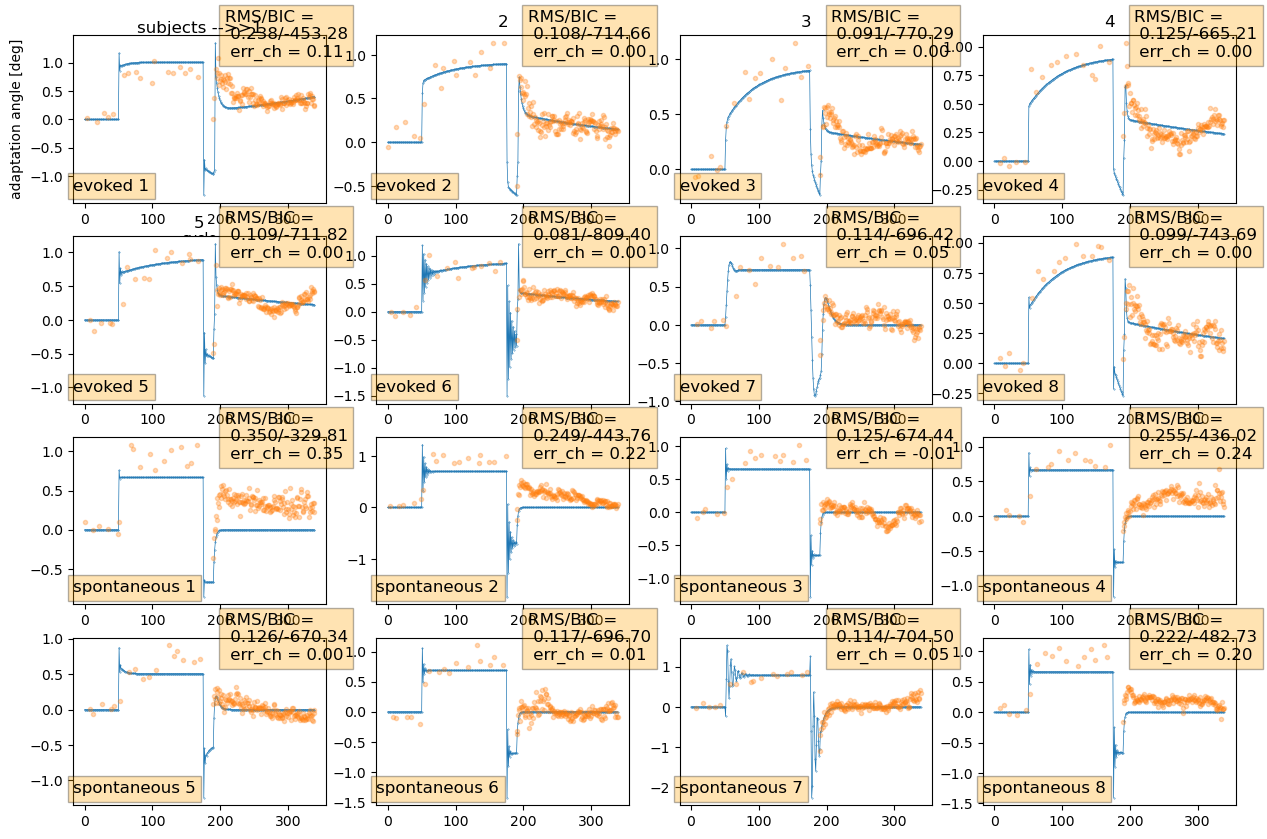

In [39]:
plt.figure(figsize=(15,10))
for k in outs:
    plt.subplot(4,4,k+1)
    ydata_model = np.array(outs[k])
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    mse = np.nanmean((ydata_model-ydata_experiment)**2)
    rms = np.sqrt(mse)
    bic_value = bic( ydata_experiment,ydata_model, 4)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],'.-',linewidth=0.5, markersize=0.6)
    plt.plot(data[k],'.', alpha=0.3)

    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

    plt.text(0.6, 1, f'RMS/BIC =\n {rms:.3f}/{bic_value:.2f}\n err_ch = {np.mean(ydata_experiment[-146:]-ydata_model[-146:]):.2f}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [38]:
[opt_param['x'] for opt_param in opt_params.values()]

[array([0.80285141, 0.57385363, 1.00578059, 0.59884861]),
 array([0.74657343, 0.51488173, 0.99463844, 0.04713994]),
 array([0.64249679, 0.23382355, 0.99704194, 0.03343715]),
 array([0.48370148, 0.4453111 , 0.9970369 , 0.03304415]),
 array([0.99661733, 0.03680228, 0.52730086, 0.971948  ]),
 array([0.33244712, 1.15218404, 0.99577476, 0.03019087]),
 array([ 0.83265059,  0.98038913,  0.73302994, -0.87766016]),
 array([0.33950119, 0.51466023, 0.99647459, 0.03279572]),
 array([0.61992505, 0.14284022, 0.62011164, 0.61848654]),
 array([0.47987831, 0.31317458, 0.47972968, 0.90566785]),
 array([0.48580298, 0.12976407, 0.4856604 , 0.83570069]),
 array([0.54377957, 0.22155333, 0.5410598 , 0.69283702]),
 array([ 0.72809388, -1.36755355,  0.62965108,  2.24138806]),
 array([0.52247235, 0.20972711, 0.52200224, 0.84849305]),
 array([ 0.83334524,  0.74643602, -0.3652642 , -0.98136862]),
 array([0.47798319, 0.2073878 , 0.47784389, 0.82904698])]

Text(0.5, 1.0, 'subjects -->>1')

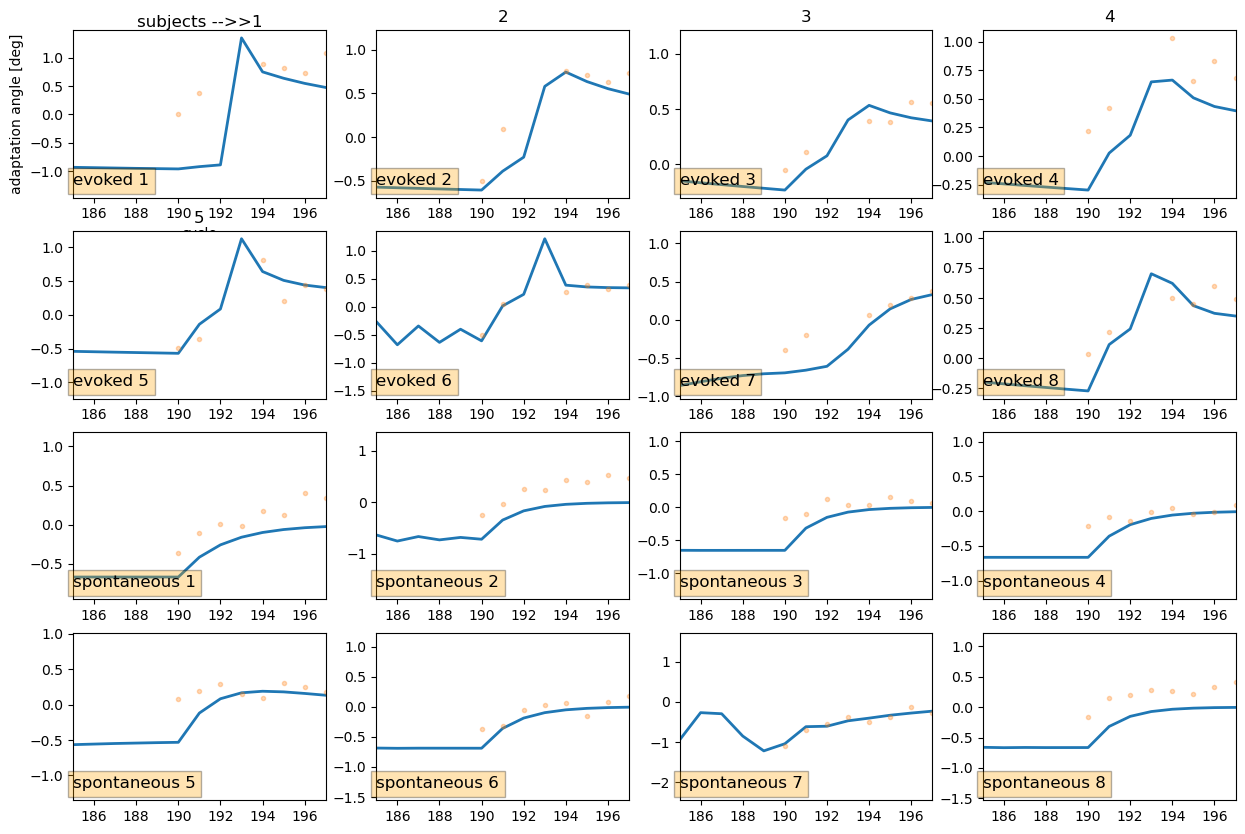

In [44]:
plt.figure(figsize=(15,10))
for k in outs:
    plt.subplot(4,4,k+1)
    ydata_model = np.array(outs[k])
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    mse = np.nanmean((ydata_model-ydata_experiment)**2)
    rms = np.sqrt(mse)
    bic_value = bic( ydata_experiment,ydata_model, 4)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    plt.xlim([185,197])

    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

    # plt.text(0.6, 0.2, f'RMS/BIC =\n {rms:.2f}/{bic_value:.2f}', 
    #              horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
    #              bbox=dict(facecolor='orange', alpha=0.3))

plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [ ]:
raise ValueError('stop here')

ValueError: stop here

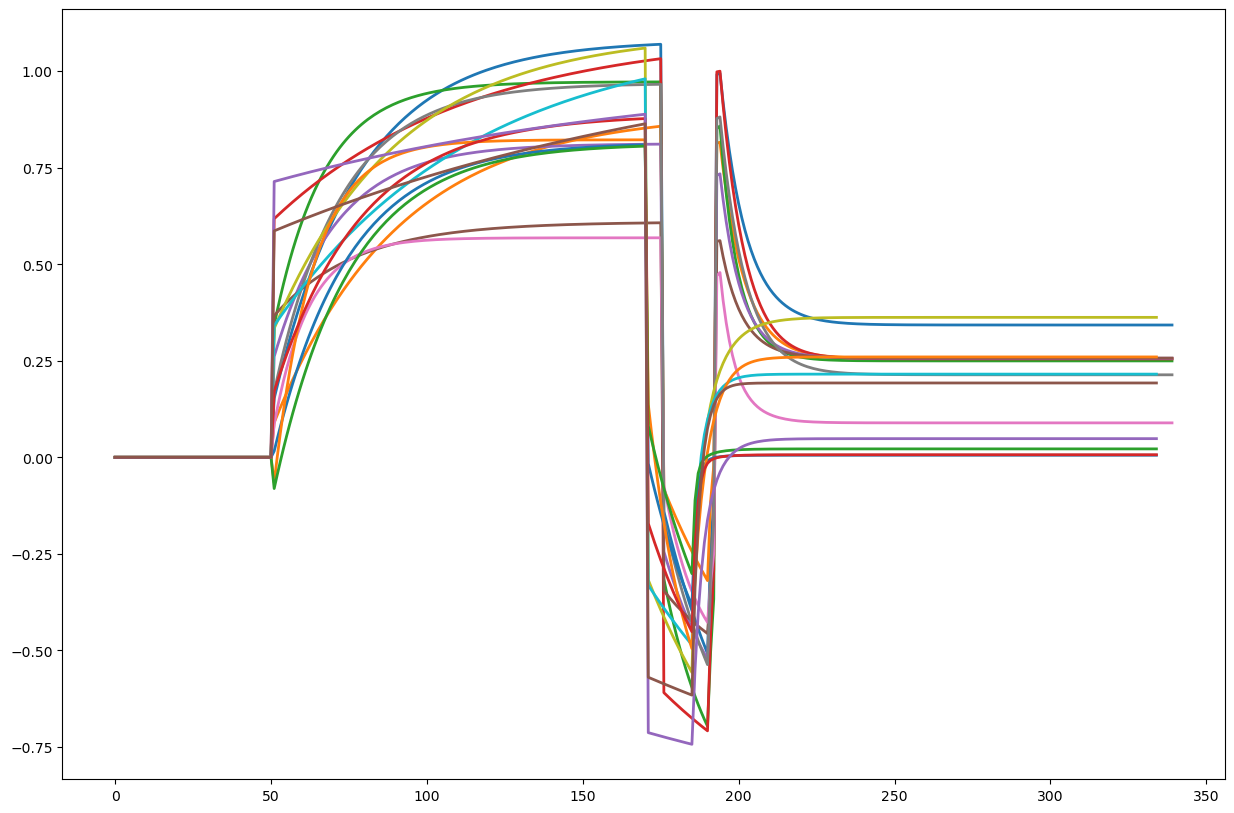

In [ ]:
plt.figure(figsize=(15,10))
for k in opt_data:
    # plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    # plt.plot(data[k],'.', alpha=0.3)
    # if k<5: plt.title(f'{k+1}')
    # plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
    #              horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
    #              bbox=dict(facecolor='orange', alpha=0.3))



# plt.subplot(4,4,1)
# # plt.ylabel('adaptation angle [deg]')
# # plt.xlabel('cycle')

# plt.gca().set_title(f'subjects -->>{1}', pad=-30)

In [ ]:
A_times = [0,5,10,20] 
antero_short   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

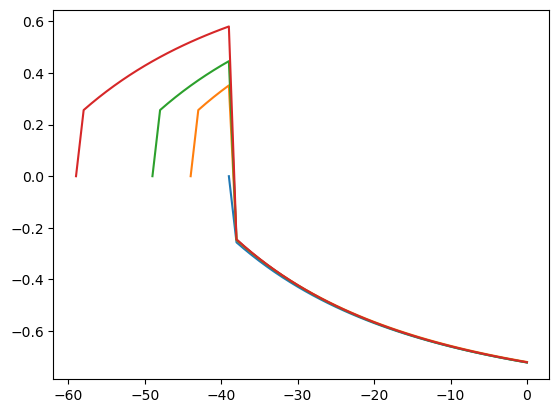

In [ ]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

In [ ]:
TaN=150
TaB=120

ref_antero_playlist = {'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)]}

antero   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in ref_antero_playlist.items()}

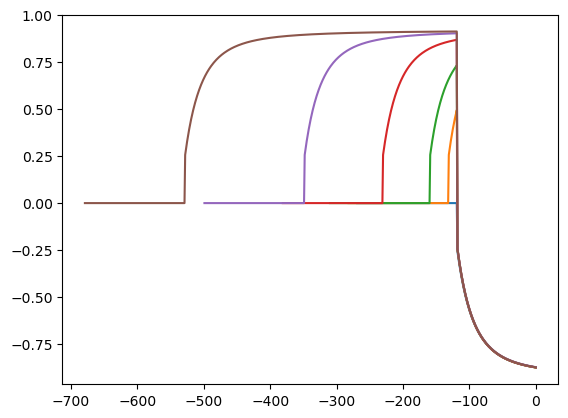

In [ ]:
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

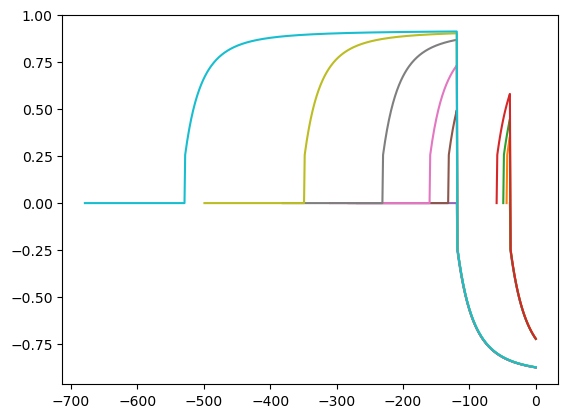

In [ ]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

In [ ]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

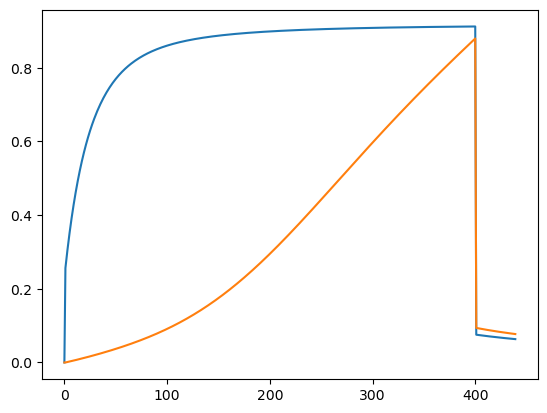

In [ ]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
from siggen_utils import herzfeld_block


def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
# her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

In [ ]:
her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

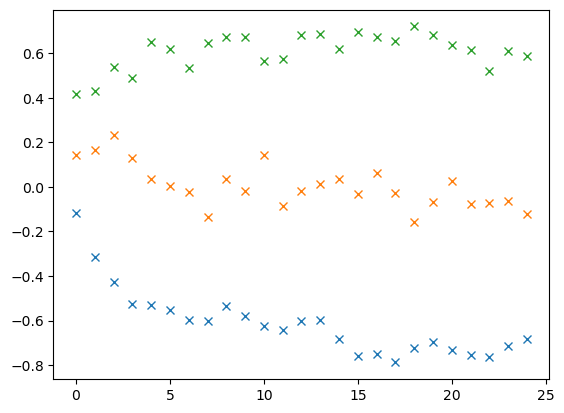

In [ ]:
for iz, z in enumerate(hrz_params['z_list']):
    deltas = []
    mm = lambda x: np.mean(x,axis=0)
    scenario = f'herzfeld,z={z}'
    this_result = her_results[scenario]
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = hrz_playlist[scenario][bb][-1]
        pointer += block_length
        deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

    plt.plot(deltas,'x',label = f'z={z}')


# for frog_en in frog_ens:
#     plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
playlist = {'Ac':[(P0, 200),(Pplus, 200),(Pchannel,200)],
            'ABc':[(P0, 200),(Pplus, 200),(Pminus, 200),(Pchannel,200)]}

results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in playlist.items()}

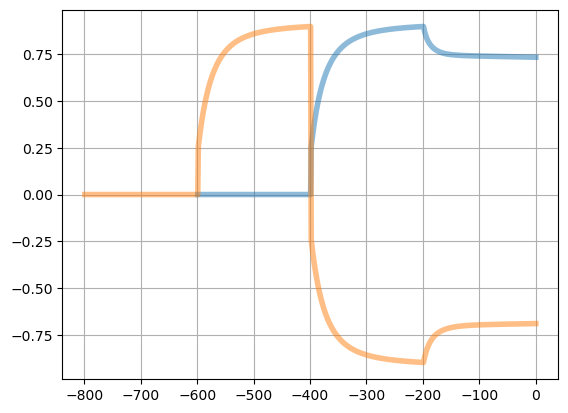

In [ ]:
for aa,aa_item in results.items():
    y = np.mean(results[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y, linewidth=4, alpha=0.5)
plt.grid()

In [ ]:
from dsp_utils import parse_samples

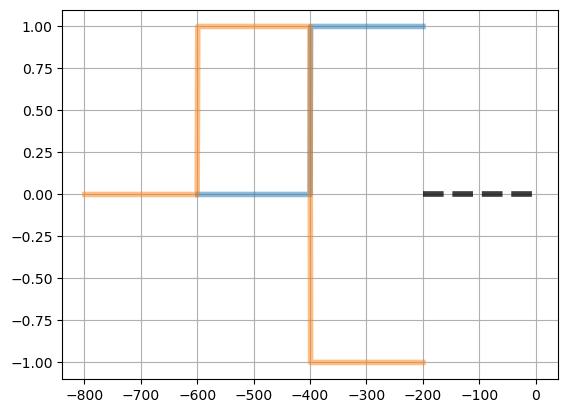

In [ ]:
for aa,aa_item in playlist.items():
    y = parse_samples(playlist[aa])
    x = np.arange(len(y))
    x = x - x[-1]    
    plt.plot(x,y, linewidth=4, alpha=0.5)
    #get a vector where nans replaced by 0 and every non-nan replaced by nan
    y_nan = np.nan*np.ones(len(y))
    y_nan[np.isnan(y)] = 0
    plt.plot(x,y_nan, 'k--',linewidth=4, alpha=0.5)
plt.grid()

In [ ]:
parse_samples(playlist[aa])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0